### This notebook is used for svm classifier.
To do list:
- [x] svm
- [x] RandomForestClassifier
- [ ] CNN?

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#plt.style.use('seaborn')
import seaborn as sns

import datetime

import os
import glob

import numpy as np
import pandas as pd
import math
from random import randrange
from random import randint

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

# import sys
# sys.path.append("/Users/hunglo/Dropbox/AG_Johenning_Schmitz/Programming/python/")
# import os
# from figures import plotinscopixtraces


Bad key "text.kerning_factor" on line 4 in
/Users/hunglo/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

# X, y = make_classification(random_state=0)
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# svc = SVC(random_state=42)
# svc.fit(X_train, y_train)
# rfc = RandomForestClassifier(random_state=42)
# rfc.fit(X_train, y_train)

# svc_disp = plot_roc_curve(svc, X_test, y_test)
# rfc_disp = plot_roc_curve(rfc, X_test, y_test, ax=svc_disp.ax_)
# rfc_disp.figure_.suptitle("ROC curve comparison")

# plt.show()

In [3]:
## Helper functions

## Def phensys converter for lick rate
def timestampconvert(x):
  stamp = datetime.timedelta(days = x)
  result = datetime.datetime(1899,12,30,0,0) + stamp
  # print(result.strftime('%Y-%m-%d %H:%M:%S.%f'))
  return result

def datetime_convert_phenosys(csv_path):
    df_pheno = pd.read_csv(csv_path)
    time_list = df_pheno['DateTime']
    result = []
    for x in time_list:
        timestampconvert(x)
        result.append(timestampconvert(x))
    new_time_stamps = []
    for i in result:
        new_time_stamps.append((i-min(result)).total_seconds())
    df_pheno = df_pheno.fillna(0)
    df_pheno['DateTime'] = new_time_stamps
    # df_pheno
    return df_pheno

## Function for getting L1 and L2 lick events
def lick_event_calculate(csv_path):
    """
    This function will calcuate the lick sensor data from the phenosys csv files and return 3 lists of timestamps from sensor L1, L2 and the timestamps of both channels. It will also do a quick plotting for the lick sensor data for raster plots and the density plot of overall lick events.

    """
    df = datetime_convert_phenosys(csv_path)
    
    # Get L1 timestamps and MsgValue1
    L1_time = df[df['unitLabel']=='L1']['DateTime'].values
    L1_value = df[df['unitLabel']=='L1']['MsgValue1'].values

    L1_timestamps_new = []
    for idx,value in enumerate(L1_value):
        if len(value.split(','))>1:
            # print(value.split(','))
            for j in value.split(',')[1:]:
                # print(j.split('-')[0])
                individual_value = int(j.split('-')[0])*0.001 # convert ms to s
                # print(L1_time[idx]+individual_value)
                if idx == 0:
                    L1_timestamps_new.append(L1_time[idx]+individual_value)
                else:
                    L1_timestamps_new.append(L1_timestamps_new[-1]+individual_value)
        else:
            L1_timestamps_new.append(L1_time[idx])

    ## The same for L2
    L2_time = df[df['unitLabel']=='L2']['DateTime'].values
    L2_value = df[df['unitLabel']=='L2']['MsgValue1'].values

    L2_timestamps_new = []
    for idx,value in enumerate(L2_value):
        if len(value.split(','))>1:
            # print(value.split(','))
            for j in value.split(',')[1:]:
                # print(j.split('-')[0])
                individual_value = int(j.split('-')[0])*0.001
                # print(L1_time[idx]+individual_value)
                if idx == 0:
                    L2_timestamps_new.append(L2_time[idx]+individual_value)
                else:
                    L2_timestamps_new.append(L2_timestamps_new[-1]+individual_value)
        else:
            L2_timestamps_new.append(L2_time[idx])

    all_lick_events = sorted(L1_timestamps_new + L2_timestamps_new)

    print('File processed: '+csv_path.split('/')[-1])
    print('Is there any duplication?: '+ str(len(L1_timestamps_new) != len(set(L1_timestamps_new))))

    fig, [ax0,ax1] = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=[8,4])
    ax0.eventplot([L1_timestamps_new,L2_timestamps_new,all_lick_events],lw=0.5,linelengths=0.8,color=['C0','C1','C3'])
    legend=ax0.legend(['L1','L2','All'],bbox_to_anchor=(0., 1.1, 1., 1.1), loc=3, ncol=3, mode="expand", 
                borderaxespad=0.,frameon=False,title='Lick events for L1 & L2 lick sensors: '+csv_path.split('/')[-1],fontsize=8)
    
    legend.get_title().set_fontsize('9')
    
    # sns.distplot(L1_timestamps_new, hist=False, rug=True, ax=ax1, color='C0',rug_kws={"height":0.2,"linewidth":0.5,"alpha":0.5})
    # sns.distplot(L2_timestamps_new, hist=False, rug=True, ax=ax1, color='C1',rug_kws={"height":0.2,"linewidth":0.5,"alpha":0.5})
    sns.distplot(all_lick_events, hist=False, rug=True, ax=ax1, color='C3',rug_kws={"height":0.2,"linewidth":0.5,"alpha":0.5})
    ax0.set_yticks([])
    ax1.set_yticks([])
    plt.xlabel('Second',fontsize=8)
    plt.xticks(fontsize=8);plt.yticks(fontsize=8)
    plt.xlim([0,1600])
    plt.tight_layout();plt.show()
    return L1_timestamps_new, L2_timestamps_new, all_lick_events



## Function for getting P1 and P1C lick events
def GPIO_event_calculate(csv_path):
    """
    This function will calcuate the lick sensor data from the phenosys csv files and return 3 lists of timestamps from GPIOs P1 and P1C and the timestamps of both channels.

    """
    df = datetime_convert_phenosys(csv_path)
    
    # Get L1 timestamps and MsgValue1
    P1_time = df[df['unitLabel']=='P1']['DateTime'].values
    P1C_time = df[df['unitLabel']=='P1C']['DateTime'].values
    
    P2_time = df[df['unitLabel']=='P2']['DateTime'].values
    P2A_time = df[df['unitLabel']=='P2A']['DateTime'].values

    # all_pump_events = P1_time + P1C_time + P2_time + P2A_time
    pump_all = np.concatenate([P1_time,P1C_time,P2_time,P2A_time],axis=0)
    pump_all = sorted(pump_all)
    pump_all = np.array(pump_all)

    # fig, ax0 = plt.subplots(nrows=1,ncols=1,sharex=True,figsize=[8,2])
    # ax0.eventplot([P1_time,P1C_time,P2_time,P2A_time],lw=0.5,linelengths=0.8,color=['C0','C1','C3','C4'])
    # legend=ax0.legend(['P1','P1C','P2','P2A'],bbox_to_anchor=(0., 1.1, 1., 1.1), loc=3, ncol=4, mode="expand", 
    #             borderaxespad=0.,frameon=False,title='GPIO events: '+csv_path.split('/')[-1],fontsize=8)
    
    # legend.get_title().set_fontsize('9')
    
    # ax0.set_yticks([])
    # plt.xlabel('Second',fontsize=8)
    # plt.xticks(fontsize=8);plt.yticks(fontsize=8)
    # plt.xlim([0,1600])
    # plt.tight_layout();plt.show()
    
    return P1_time, P1C_time, P2_time, P2A_time, pump_all

## Filter function for np array
def filter_mask_large(arr, j):
    return arr[arr < j]
def filter_mask_small(arr, k):
    return arr[arr > k]

## find nearst value in np array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


In [4]:
## Plotting setting
plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({'font.size': 10})

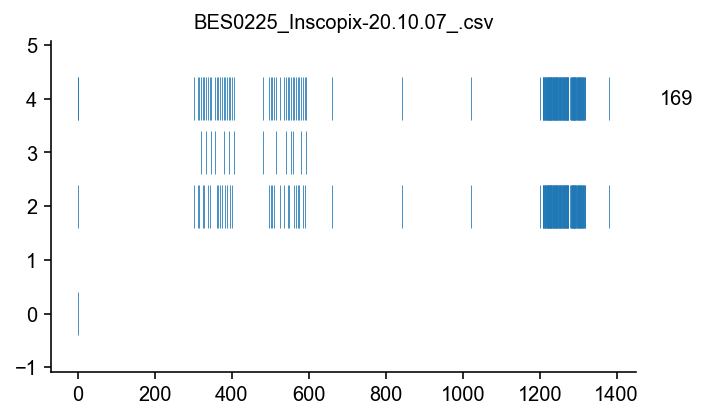

In [7]:
## Load GPIO data with GPIO_event_calculate() function.

## which mouse?
mouse_id = 'BES0225'

# Locate file folder
GPIO_folder = '/Users/hunglo/Desktop/GPIO_phenosys_log_file/'+mouse_id+'/processed/'

extension = 'csv'
os.chdir(GPIO_folder)
result = sorted(glob.glob('*.{}'.format(extension)))
# print(result)
idx = -2
P1, P1C, P2, P2A, Pump_all = GPIO_event_calculate(GPIO_folder+result[idx])

plt.figure(figsize=[5,3])
plt.title(result[idx],fontsize=10)
plt.eventplot(Pump_all,lineoffsets = 4,linelengths = 0.8,linewidths=0.4)
plt.eventplot([P1,P1C,P2,P2A],linelengths = 0.8,linewidths=0.4)
plt.text(s=len(Pump_all),x=1600,y=4,va='center',ha='right')
sns.despine()
plt.tight_layout()

In [10]:
## Load Ca2+ dFF
dff_path = '/Users/hunglo/Desktop/3rd_supervision/Ca2_trace_csv/CNMFe_pnr20_mincorr08/BES0225201007_celltraces.csv'
df_dff=pd.read_csv(dff_path, header=0,skiprows=[1],index_col=0)
df_dff.head()

save_file_name = dff_path.split('.')[0].split('/')[-1].split('_')[0]
# save_file_name

sort = 1

if sort == True:
    ## Load Inscopix_GPIO to align Ca2+ data with phenosys
    file_path = dff_path[0:-14]+'GPIO.csv'
    sheet=pd.read_csv(file_path, header=[0], index_col=0)
    gpiosub=sheet.loc[sheet[' Channel Name']== ' GPIO-3']

    ## Change this line for IO1 or IO2
    # gpiosub=sheet.loc[sheet[' Channel Name']== ' IO1']
    Inscopix_GPIO_init = gpiosub[' Value'][300:315].idxmin()

    # Inscopix_GPIO_init
    # Calculate time difference
    if len(P1) == 1:
        if np.min(abs(find_nearest(P2,300)-300)) > np.min(abs(find_nearest(P2A,300)-300)):
            time_diff = Inscopix_GPIO_init - find_nearest(P2A,300)
        else:
            time_diff = Inscopix_GPIO_init - find_nearest(P2,300)
    else:
        if abs(find_nearest(P1,300)-300) > abs(find_nearest(P1C,300)-300):
            time_diff = Inscopix_GPIO_init - find_nearest(P1C,300)
        else:
            time_diff = Inscopix_GPIO_init - find_nearest(P1,300)
else:
    time_diff = 0
print(time_diff)

df_dff.index = df_dff.index - time_diff
df_dff

from scipy import stats

# z-score
df_z = df_dff.apply(stats.zscore,axis=0)
df_z


7.477002000000027


,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C142,C143,C144,C145,C146,C147,C148,C149,C150,C151
,,,,,,,,,,,,,,,,,,,,,
-7.477002,0.064216,0.382187,4.384989,-0.265930,5.120221,0.626019,-0.810883,-0.814587,-0.516503,-0.471181,...,-0.440023,-0.903304,-0.841399,-0.321037,-0.435046,-0.384297,-0.246700,-0.686506,-0.422385,-0.751361
-7.427041,1.496328,0.287780,3.773582,-0.144268,4.582523,0.530048,-0.810883,-0.814587,-0.516503,-0.051165,...,-0.440023,-0.655774,-0.841399,-0.321037,-0.435046,-0.384297,5.124311,-0.686506,-0.430845,-0.751361
-7.377080,2.042311,0.203380,3.237008,4.692959,4.096293,0.441628,-0.810883,-0.814587,1.673305,-0.113957,...,-0.440023,-0.675509,-0.841399,-0.321037,-0.435046,-0.384297,6.977392,-0.686506,-0.438457,-0.646556
-7.327119,1.760305,0.127928,2.766109,14.089607,3.656607,0.360164,-0.810883,-0.814587,1.379943,-0.169274,...,-0.440023,-0.694045,-0.841399,-0.321037,-0.435046,-0.384297,6.790227,-0.686506,-0.445305,-0.647892
-7.277158,1.509807,0.060475,2.352846,20.044906,3.259006,0.285109,-0.810883,-0.814587,1.125883,-0.218004,...,-0.440023,-0.711457,-0.841399,-0.321037,-0.435046,-0.384297,7.054197,-0.686506,-0.451466,-0.420124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106.123103,-0.291778,0.171217,-0.513390,-0.088856,-0.481368,-0.593815,0.146113,0.674535,-0.510422,-0.414440,...,-0.381216,-0.980938,-0.497144,0.506015,-0.380770,-0.384297,-0.291709,-0.680315,0.591406,-0.751361
2106.173064,-0.312995,0.099174,-0.525251,-0.119362,-0.482882,-0.593815,0.047377,0.513590,0.046159,-0.433979,...,-0.386439,-0.980938,-0.523291,0.411659,-0.385575,-0.384297,-0.293915,-0.680739,0.481240,-0.751361
2106.223025,-0.331841,0.034770,-0.535661,-0.146843,-0.484251,-0.593815,0.547318,0.370040,-0.029219,-0.451192,...,-0.391198,-0.980938,-0.547453,0.328068,-0.389956,-0.384297,-0.295900,-0.681133,0.382127,-0.751361


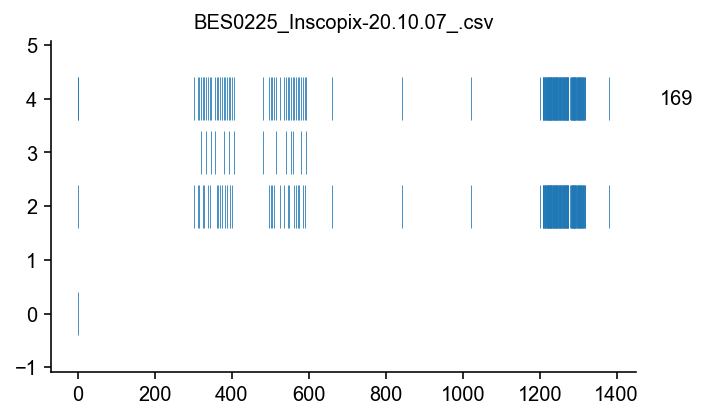

In [11]:
plt.figure(figsize=[5,3])
plt.title(result[idx],fontsize=10)
plt.eventplot(Pump_all,lineoffsets = 4,linelengths = 0.8,linewidths=0.4)
plt.eventplot([P1,P1C,P2,P2A],linelengths = 0.8,linewidths=0.4)
plt.text(s=len(Pump_all),x=1600,y=4,va='center',ha='right')
sns.despine()
plt.tight_layout()

In [13]:
## Convert GPIO data to pd dataframe with timestamps as index, easier to remove individual timestamps.
## Make P1, P1C into dateframe
GPIO1_df = pd.DataFrame([P2,np.ones(len(P2))]).T
GPIO1_df.columns = ['timestamps', 'value']
GPIO1_df = GPIO1_df.set_index('timestamps')
GPIO1C_df = pd.DataFrame([P2A,np.ones(len(P2A))]).T
GPIO1C_df.columns = ['timestamps', 'value']
GPIO1C_df = GPIO1C_df.set_index('timestamps')

## New capture single licks in rounds and remove initial pumps.
# Get single lick trials
# Get GPIO1 and GPIO1C timestamp for 4 sec time window.
# Define first single lick round
# From 300-450 sec for first lick round
s_lick_p1_1 = GPIO1_df[300:450].index.values[1:] # no init
s_lick_p1_2 = GPIO1_df[450:600].index.values[0:] # no init
s_lick_p1_3 = np.array([])
s_lick_p1_4 = np.array([])
s_lick_p1_5 = np.array([])

import itertools

s_lick_p1_combined = [s_lick_p1_1, s_lick_p1_2, s_lick_p1_3, s_lick_p1_4, s_lick_p1_5]
s_lick_p1_flatten = list(itertools.chain.from_iterable(s_lick_p1_combined))
s_lick_p1_flatten 
print(len(s_lick_p1_flatten)) 

# for pump 1c (water) and remove init
s_lick_p1C_1 = GPIO1C_df[300:450].index.values[0:]
s_lick_p1C_2 = GPIO1C_df[450:600].index.values[1:]
# s_lick_p1C_3 = GPIO1C_df[650:800].index.values[1:] 
s_lick_p1C_3 = np.array([])
s_lick_p1C_4 = np.array([])
s_lick_p1C_5 = np.array([])

s_lick_p1C_combined = [s_lick_p1C_1, s_lick_p1C_2, s_lick_p1C_3, s_lick_p1C_4, s_lick_p1C_5]
s_lick_p1C_flatten = list(itertools.chain.from_iterable(s_lick_p1C_combined))
print(len(s_lick_p1C_flatten)) 

28
13


Trial: 1
0.9583333333333334 0.6388888888888888
Trial: 2
0.6944444444444445 0.638888888888889
Trial: 3
0.6527777777777778 0.6805555555555555
Trial: 4
0.5666666666666667 0.6083333333333333
Trial: 5
0.5833333333333334 0.625
Trial: 6
0.6833333333333332 0.7999999999999999
Trial: 7
0.625 0.7083333333333334
Trial: 8
0.7666666666666666 0.7083333333333334
Trial: 9
0.5666666666666667 0.6583333333333333
Trial: 10
0.7000000000000001 0.8083333333333332
Trial: 11
0.75 0.8333333333333334
Trial: 12
0.6 0.6833333333333332
Trial: 13
0.5972222222222222 0.5972222222222222
Trial: 14
0.7222222222222222 0.5833333333333334
Trial: 15
0.65 0.6083333333333333
Trial: 16
0.7083333333333334 0.8333333333333334
Trial: 17
0.6527777777777778 0.5277777777777778
Trial: 18
0.611111111111111 0.6805555555555555
Trial: 19
0.7361111111111112 0.6527777777777778
Trial: 20
0.7166666666666667 0.6833333333333332
Trial: 21
0.5 0.5416666666666666
Trial: 22
0.611111111111111 0.611111111111111
Trial: 23
0.5583333333333333 0.6916666666

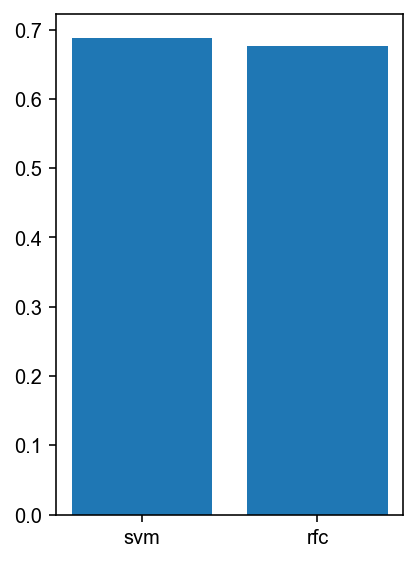

In [14]:
## Now write all PSTH groupping and svm together here in a big for loop to get average of 100 times of random picking.

data = df_z.copy()

score_svm_avg_100 = []
score_rfc_avg_100 = []

for j in range(100):
    milk_trials = []
    water_trials = []
    # Balance classes by their lengths
    # Rondomly pick up same amount of milk deliveries as water deliveries
    milk_trials = np.random.choice(s_lick_p1_flatten,len(s_lick_p1C_flatten))
    water_trials = s_lick_p1C_flatten

    ## Design matrix of max Ca2+ amplitude within 2 sec after the onset
    PSTH_trace = pd.DataFrame()
    for idx,time in enumerate(milk_trials):
        PSTH_trace[time]=(data[time:time+2].max().reset_index(drop=True))
    PSTH_trace = PSTH_trace.T
    PSTH_trace['Milk']=np.ones(PSTH_trace.shape[0])

    PSTH_trace_w = pd.DataFrame()
    for idx,time in enumerate(water_trials):
        PSTH_trace_w[time]=(data[time:time+2].max().reset_index(drop=True))
    PSTH_trace_w = PSTH_trace_w.T
    PSTH_trace_w['Milk']=np.zeros(PSTH_trace_w.shape[0])

    PSTH_all = pd.concat([PSTH_trace,PSTH_trace_w])

    ## Shuffle data frame rows (not necessary but nice to make the CV more diverse)
    PSTH_all = PSTH_all.sample(frac=1).reset_index(drop=True)
    # PSTH_all.head()

    ## SVM & RFC

    # Set x & y
    X = PSTH_all.iloc[:,:-1]
    y = PSTH_all.iloc[:,-1]

    # CV
    cv = StratifiedKFold(n_splits=6)
    svc = svm.SVC(kernel='linear', probability=True)
    rfc = RandomForestClassifier()

    score_svm = []
    auc_svm = []
    score_rfc = []
    auc_rfc = []

    mean_fpr = np.linspace(0, 1, 100)

    # fig, ax = plt.subplots(figsize=[6,5])
    for i, (train, test) in enumerate(cv.split(X, y)):
        svc.fit(X.iloc[train], y.iloc[train])
        rfc.fit(X.iloc[train], y.iloc[train])

        score_svm.append(svc.score(X.iloc[test], y.iloc[test]))
        score_rfc.append(rfc.score(X.iloc[test], y.iloc[test]))

    score_svm_avg_100.append(np.mean(score_svm))
    score_rfc_avg_100.append(np.mean(score_rfc))    
    print('Trial:',j+1)
    print(np.mean(score_svm),np.mean(score_rfc))
plt.figure(figsize=[3,4])
plt.bar(['svm','rfc'],[np.mean(score_svm_avg_100),np.mean(score_rfc_avg_100)])

plt.tight_layout()

Trial: 1
0.65 0.5
Trial: 2
0.5333333333333333 0.45
Trial: 3
0.2833333333333333 0.5333333333333333
Trial: 4
0.5 0.6166666666666666
Trial: 5
0.4333333333333333 0.36666666666666664
Trial: 6
0.7166666666666666 0.7666666666666666
Trial: 7
0.6166666666666666 0.6166666666666666
Trial: 8
0.4333333333333333 0.6166666666666666
Trial: 9
0.7833333333333333 0.5166666666666666
Trial: 10
0.4 0.2333333333333333
Trial: 11
0.6166666666666666 0.6333333333333333
Trial: 12
0.5333333333333333 0.3833333333333333
Trial: 13
0.5166666666666666 0.5333333333333333
Trial: 14
0.3 0.4666666666666666
Trial: 15
0.55 0.4333333333333333
Trial: 16
0.6166666666666666 0.5833333333333333
Trial: 17
0.5166666666666666 0.6833333333333333
Trial: 18
0.2333333333333333 0.5833333333333333
Trial: 19
0.5333333333333333 0.55
Trial: 20
0.65 0.6833333333333333
Trial: 21
0.5333333333333334 0.55
Trial: 22
0.5666666666666667 0.5833333333333333
Trial: 23
0.41666666666666663 0.36666666666666664
Trial: 24
0.36666666666666664 0.4
Trial: 25
0.

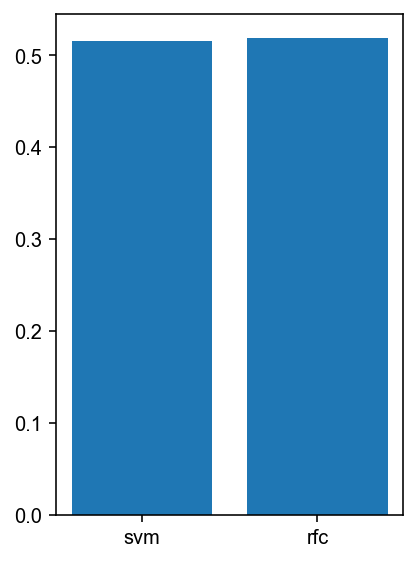

In [15]:
## Now control for shuffle labled data
data = df_z.copy()

score_svm_avg_100_s = []
score_rfc_avg_100_s = []

for j in range(100):
    milk_trials = []
    water_trials = []
    # Balance classes by their lengths
    # Rondomly pick up same amount of milk deliveries as water deliveries
    milk_trials = np.random.choice(s_lick_p1_flatten,len(s_lick_p1C_flatten))
    water_trials = s_lick_p1C_flatten

    ## Design matrix of max Ca2+ amplitude within 2 sec after the onset
    PSTH_trace = pd.DataFrame()
    for idx,time in enumerate(milk_trials):
        PSTH_trace[time]=(data[time:time+2].max().reset_index(drop=True))
    PSTH_trace = PSTH_trace.T
    PSTH_trace['Milk']=np.ones(PSTH_trace.shape[0])

    PSTH_trace_w = pd.DataFrame()
    for idx,time in enumerate(water_trials):
        PSTH_trace_w[time]=(data[time:time+2].max().reset_index(drop=True))
    PSTH_trace_w = PSTH_trace_w.T
    PSTH_trace_w['Milk']=np.zeros(PSTH_trace_w.shape[0])

    PSTH_all = pd.concat([PSTH_trace,PSTH_trace_w])
    # PSTH_all.head()
    PSTH_all_shuffle = PSTH_all.copy().reset_index(drop=True)

    ## Shuffle data labels column
    PSTH_all_shuffle['Milk'] = PSTH_all_shuffle['Milk'].sample(frac=1).reset_index(drop=True)
    
    ## Shuffle data frame (all rows), not necessary.
    PSTH_all_shuffle = PSTH_all_shuffle.sample(frac=1).reset_index(drop=True)

    ## Perform svm & rfc

    ## Set x & y
    X = PSTH_all_shuffle.iloc[:,:-1]
    y = PSTH_all_shuffle.iloc[:,-1]

    # CV
    cv = StratifiedKFold(n_splits=10)
    svc = svm.SVC(kernel='linear', probability=True)
    rfc = RandomForestClassifier()

    score_svm = []
    auc_svm = []
    score_rfc = []
    auc_rfc = []

    for i, (train, test) in enumerate(cv.split(X, y)):
        svc.fit(X.iloc[train], y.iloc[train])
        rfc.fit(X.iloc[train], y.iloc[train])

        score_svm.append(svc.score(X.iloc[test], y.iloc[test]))
        score_rfc.append(rfc.score(X.iloc[test], y.iloc[test]))
        
    score_svm_avg_100_s.append(np.mean(score_svm))
    score_rfc_avg_100_s.append(np.mean(score_rfc))    
    print('Trial:',j+1)
    print(np.mean(score_svm),np.mean(score_rfc))
plt.figure(figsize=[3,4])
plt.bar(['svm','rfc'],[np.mean(score_svm_avg_100_s),np.mean(score_rfc_avg_100_s)])
plt.tight_layout()

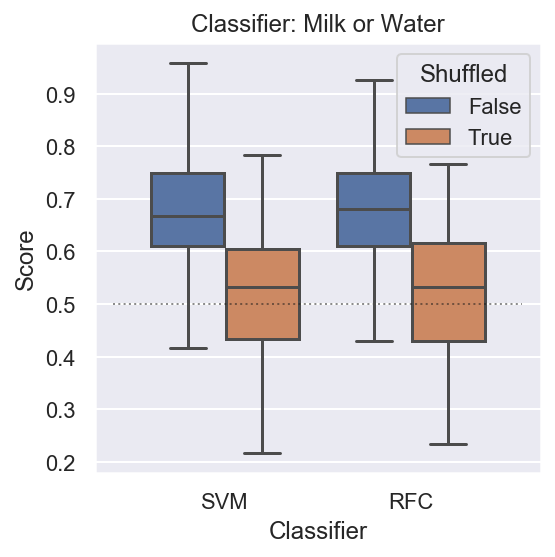

In [16]:
## Plotting setting
plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({'font.size': 8})

## More clear plot with sns
## Only with svm + rfc (combined with shuffled dat)
score = pd.DataFrame([score_svm_avg_100,score_rfc_avg_100])
score = score.T
score.columns=['SVM','RFC']
score = score.melt(var_name="Classifier")
score.columns=['Classifier','Score']
score['Shuffled'] = np.zeros(score.shape[0],dtype=bool)

score_s = pd.DataFrame([score_svm_avg_100_s,score_rfc_avg_100_s])
score_s = score_s.T
score_s.columns=['SVM','RFC']
score_s = score_s.melt(var_name="Classifier")
score_s.columns=['Classifier','Score']
score_s['Shuffled'] = np.ones(score_s.shape[0],dtype=bool)

score_all = pd.concat([score,score_s])
data = score_all
# data = score

sns.set()

from numpy import median
from scipy.stats import sem

sem_svm = sem(score_svm_avg_100)
sem_rfc = sem(score_rfc_avg_100)
error_sem = [sem_svm,sem_rfc]

std_svm = np.std(score_svm_avg_100)
std_rfc = np.std(score_rfc_avg_100)
error_std = [std_svm,std_rfc]

fig,ax = plt.subplots(figsize=[4,4])
sns.boxplot(x="Classifier", y="Score",data=data,hue='Shuffled')
plt.hlines(y=0.5,xmin=-0.6,xmax=1.6,ls=':',lw=1,label='Chance level',alpha=0.5)

plt.title('Classifier: Milk or Water')
plt.tight_layout()
plt.savefig('/Users/hunglo/Desktop/3rd_supervision/svm/svm_rfc_boxplot_'+save_file_name+'.pdf',dpi=600)
plt.show()

score_all.to_csv('/Users/hunglo/Desktop/3rd_supervision/svm/svm_rfc_score_'+save_file_name+'.csv')

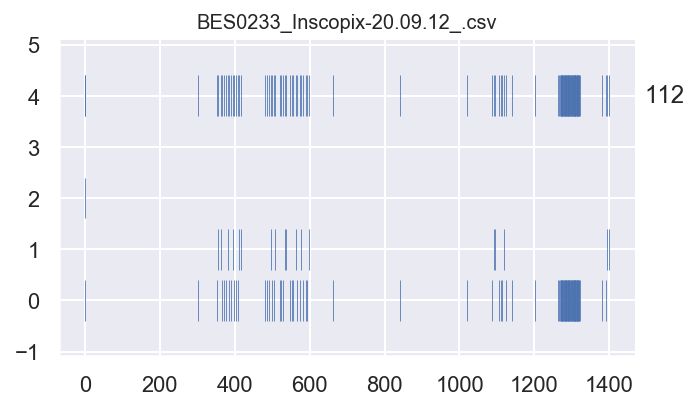

In [21]:
## For BES0233
## Load GPIO data with GPIO_event_calculate() function.

## which mouse?
mouse_id = 'BES0233'

# Locate file folder
GPIO_folder = '/Users/hunglo/Desktop/GPIO_phenosys_log_file/'+mouse_id+'/processed/'

extension = 'csv'
os.chdir(GPIO_folder)
result = sorted(glob.glob('*.{}'.format(extension)))
# print(result)
idx = 4
P1, P1C, P2, P2A, Pump_all = GPIO_event_calculate(GPIO_folder+result[idx])

plt.figure(figsize=[5,3])
plt.title(result[idx],fontsize=10)
plt.eventplot(Pump_all,lineoffsets = 4,linelengths = 0.8,linewidths=0.4)
plt.eventplot([P1,P1C,P2,P2A],linelengths = 0.8,linewidths=0.4)
plt.text(s=len(Pump_all),x=1600,y=4,va='center',ha='right')
sns.despine()
plt.tight_layout()

In [22]:
## Load Ca2+ dFF
dff_path = '/Users/hunglo/Desktop/3rd_supervision/Ca2_trace_csv/CNMFe_pnr20_mincorr08/BES0233200912_celltraces.csv'
df_dff=pd.read_csv(dff_path, header=0,skiprows=[1],index_col=0)
df_dff.head()

save_file_name = dff_path.split('.')[0].split('/')[-1].split('_')[0]
# save_file_name

sort = 1

if sort == True:
    ## Load Inscopix_GPIO to align Ca2+ data with phenosys
    file_path = dff_path[0:-14]+'GPIO.csv'
    sheet=pd.read_csv(file_path, header=[0], index_col=0)
    gpiosub=sheet.loc[sheet[' Channel Name']== ' GPIO-1']

    ## Change this line for IO1 or IO2
    # gpiosub=sheet.loc[sheet[' Channel Name']== ' IO1']
    Inscopix_GPIO_init = gpiosub[' Value'][300:315].idxmin()

    # Inscopix_GPIO_init
    # Calculate time difference
    if len(P1) == 1:
        if np.min(abs(find_nearest(P2,300)-300)) > np.min(abs(find_nearest(P2A,300)-300)):
            time_diff = Inscopix_GPIO_init - find_nearest(P2A,300)
        else:
            time_diff = Inscopix_GPIO_init - find_nearest(P2,300)
    else:
        if abs(find_nearest(P1,300)-300) > abs(find_nearest(P1C,300)-300):
            time_diff = Inscopix_GPIO_init - find_nearest(P1C,300)
        else:
            time_diff = Inscopix_GPIO_init - find_nearest(P1,300)
else:
    time_diff = 0
print(time_diff)

df_dff.index = df_dff.index - time_diff
df_dff

from scipy import stats

# z-score
df_z = df_dff.apply(stats.zscore,axis=0)
df_z


8.132992999999999


,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C120,C121,C122,C123,C124,C125,C126,C127,C128,C129
,,,,,,,,,,,,,,,,,,,,,
-8.132993,-0.628638,2.576404,-0.274207,-0.618150,0.317583,0.029423,0.887646,-0.962269,0.954081,-0.721850,...,-0.609554,-0.760014,-0.618766,-0.527857,-0.740707,-0.500539,-0.639414,-0.696922,-0.534414,-0.474916
-8.083032,-0.628638,3.175349,-0.317356,-0.414466,0.486357,-0.033324,0.697761,-0.962269,0.772259,-0.722960,...,-0.609554,-0.760014,-0.233467,-0.527857,-0.740707,-0.500539,-0.641331,-0.696922,-0.534414,-0.474916
-8.033071,-0.628638,3.946284,-0.356425,-0.435536,0.371606,-0.090929,0.531829,-0.962269,0.609757,-0.723960,...,-0.457705,-0.760014,0.041893,-0.527857,-0.740707,-0.500539,-0.643080,-0.696922,-0.534414,-0.474916
-7.983110,-0.628638,6.074697,-0.382139,-0.454425,0.269905,-0.143812,0.386829,-0.501305,0.464522,-0.724860,...,-0.469579,-0.760014,0.307670,-0.527857,-0.740707,-0.480234,-0.644676,-0.696922,-0.534414,-0.474916
-7.933149,-0.628638,9.852728,-0.415082,-0.471361,0.179772,-0.192360,0.260120,-0.550600,0.334719,-0.725671,...,0.167929,-0.760014,0.221004,0.319671,-0.740707,-0.482104,-0.646132,-0.696922,-0.534414,-0.474916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503.487023,-0.456572,-0.015159,-0.701357,-0.107805,0.347009,-0.736105,-0.589580,-0.832012,-0.757098,-0.664747,...,-0.609554,0.135163,-0.618766,-0.243445,-0.740707,-0.442600,-0.328497,0.764501,-0.436454,-0.193373
1503.536984,-0.469382,-0.057059,-0.704117,0.101133,0.248106,-0.736105,-0.593118,-0.845942,-0.757099,-0.671524,...,-0.609554,0.074567,-0.618766,-0.265144,-0.740707,-0.447937,-0.357696,0.665468,-0.445028,-0.218421
1503.586945,-0.481239,-0.095691,-0.706615,0.026730,0.160452,-0.736105,-0.596210,-0.858382,-0.757099,-0.677627,...,-0.609554,0.018072,-0.618766,-0.285188,-0.740707,-0.452783,-0.384333,0.573146,-0.452852,-0.241240


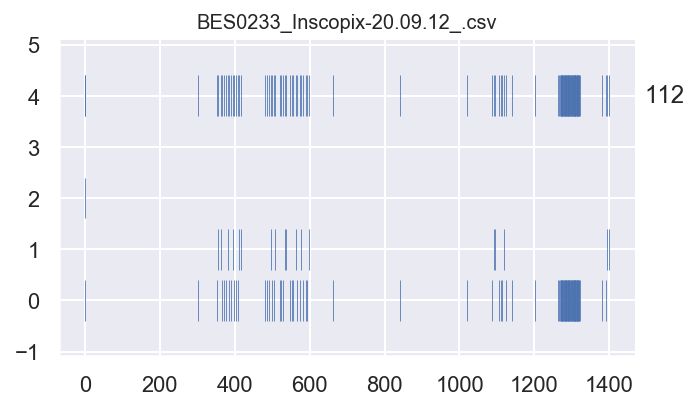

In [23]:
plt.figure(figsize=[5,3])
plt.title(result[idx],fontsize=10)
plt.eventplot(Pump_all,lineoffsets = 4,linelengths = 0.8,linewidths=0.4)
plt.eventplot([P1,P1C,P2,P2A],linelengths = 0.8,linewidths=0.4)
plt.text(s=len(Pump_all),x=1600,y=4,va='center',ha='right')
sns.despine()
plt.tight_layout()

In [24]:
## Convert GPIO data to pd dataframe with timestamps as index, easier to remove individual timestamps.
## Make P1, P1C into dateframe
GPIO1_df = pd.DataFrame([P1,np.ones(len(P1))]).T
GPIO1_df.columns = ['timestamps', 'value']
GPIO1_df = GPIO1_df.set_index('timestamps')
GPIO1C_df = pd.DataFrame([P1C,np.ones(len(P1C))]).T
GPIO1C_df.columns = ['timestamps', 'value']
GPIO1C_df = GPIO1C_df.set_index('timestamps')

## New capture single licks in rounds and remove initial pumps.
# Get single lick trials
# Get GPIO1 and GPIO1C timestamp for 4 sec time window.
# Define first single lick round
# From 300-450 sec for first lick round
s_lick_p1_1 = GPIO1_df[300:450].index.values[1:] # no init
s_lick_p1_2 = GPIO1_df[450:600].index.values[1:] # no init
s_lick_p1_3 = np.array([])
s_lick_p1_4 = GPIO1_df[1000:1200].index.values[1:]
s_lick_p1_5 = GPIO1_df[1350:].index.values[1:]

import itertools

s_lick_p1_combined = [s_lick_p1_1, s_lick_p1_2, s_lick_p1_3, s_lick_p1_4, s_lick_p1_5]
s_lick_p1_flatten = list(itertools.chain.from_iterable(s_lick_p1_combined))
s_lick_p1_flatten 
print(len(s_lick_p1_flatten)) 

# for pump 1c (water) and remove init
s_lick_p1C_1 = GPIO1C_df[300:450].index.values[0:]
s_lick_p1C_2 = GPIO1C_df[450:600].index.values[0:]
s_lick_p1C_3 = np.array([])
s_lick_p1C_4 = GPIO1C_df[1000:1200].index.values[0:]
s_lick_p1C_5 = GPIO1C_df[1350:].index.values[0:]

s_lick_p1C_combined = [s_lick_p1C_1, s_lick_p1C_2, s_lick_p1C_3, s_lick_p1C_4, s_lick_p1C_5]
s_lick_p1C_flatten = list(itertools.chain.from_iterable(s_lick_p1C_combined))
print(len(s_lick_p1C_flatten)) 

31
18


Trial: 1
0.5388888888888889 0.6222222222222221
Trial: 2
0.5166666666666667 0.4833333333333334
Trial: 3
0.29444444444444445 0.4055555555555556
Trial: 4
0.4666666666666666 0.6000000000000001
Trial: 5
0.5499999999999999 0.4222222222222222
Trial: 6
0.5166666666666667 0.45555555555555555
Trial: 7
0.4166666666666667 0.39999999999999997
Trial: 8
0.7055555555555556 0.6111111111111112
Trial: 9
0.43888888888888883 0.4666666666666666
Trial: 10
0.5 0.5277777777777778
Trial: 11
0.6611111111111111 0.6333333333333334
Trial: 12
0.6000000000000001 0.5499999999999999
Trial: 13
0.6 0.5
Trial: 14
0.5333333333333333 0.5444444444444444
Trial: 15
0.4444444444444445 0.45
Trial: 16
0.4611111111111112 0.5944444444444444
Trial: 17
0.5222222222222223 0.47222222222222227
Trial: 18
0.5333333333333333 0.43333333333333335
Trial: 19
0.37222222222222223 0.5333333333333334
Trial: 20
0.3 0.47222222222222215
Trial: 21
0.4055555555555556 0.5000000000000001
Trial: 22
0.6499999999999999 0.5722222222222223
Trial: 23
0.6 0.533

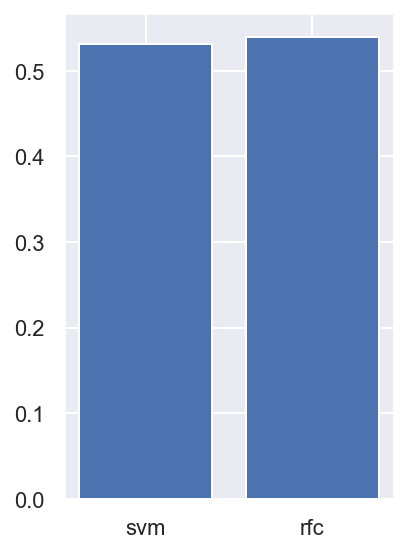

In [25]:
## Now write all PSTH groupping and svm together here in a big for loop to get average of 100 times of random picking.

data = df_z.copy()

score_svm_avg_100 = []
score_rfc_avg_100 = []

for j in range(100):
    milk_trials = []
    water_trials = []
    # Balance classes by their lengths
    # Rondomly pick up same amount of milk deliveries as water deliveries
    milk_trials = np.random.choice(s_lick_p1_flatten,len(s_lick_p1C_flatten))
    water_trials = s_lick_p1C_flatten

    ## Design matrix of max Ca2+ amplitude within 2 sec after the onset
    PSTH_trace = pd.DataFrame()
    for idx,time in enumerate(milk_trials):
        PSTH_trace[time]=(data[time:time+2].max().reset_index(drop=True))
    PSTH_trace = PSTH_trace.T
    PSTH_trace['Milk']=np.ones(PSTH_trace.shape[0])

    PSTH_trace_w = pd.DataFrame()
    for idx,time in enumerate(water_trials):
        PSTH_trace_w[time]=(data[time:time+2].max().reset_index(drop=True))
    PSTH_trace_w = PSTH_trace_w.T
    PSTH_trace_w['Milk']=np.zeros(PSTH_trace_w.shape[0])

    PSTH_all = pd.concat([PSTH_trace,PSTH_trace_w])

    ## Shuffle data frame rows (not necessary but nice to make the CV more diverse)
    PSTH_all = PSTH_all.sample(frac=1).reset_index(drop=True)
    # PSTH_all.head()

    ## SVM & RFC

    # Set x & y
    X = PSTH_all.iloc[:,:-1]
    y = PSTH_all.iloc[:,-1]

    # CV
    cv = StratifiedKFold(n_splits=6)
    svc = svm.SVC(kernel='linear', probability=True)
    rfc = RandomForestClassifier()

    score_svm = []
    auc_svm = []
    score_rfc = []
    auc_rfc = []

    mean_fpr = np.linspace(0, 1, 100)

    # fig, ax = plt.subplots(figsize=[6,5])
    for i, (train, test) in enumerate(cv.split(X, y)):
        svc.fit(X.iloc[train], y.iloc[train])
        rfc.fit(X.iloc[train], y.iloc[train])

        score_svm.append(svc.score(X.iloc[test], y.iloc[test]))
        score_rfc.append(rfc.score(X.iloc[test], y.iloc[test]))

    score_svm_avg_100.append(np.mean(score_svm))
    score_rfc_avg_100.append(np.mean(score_rfc))    
    print('Trial:',j+1)
    print(np.mean(score_svm),np.mean(score_rfc))
plt.figure(figsize=[3,4])
plt.bar(['svm','rfc'],[np.mean(score_svm_avg_100),np.mean(score_rfc_avg_100)])

plt.tight_layout()

Trial: 1
0.6 0.6333333333333333
Trial: 2
0.575 0.3833333333333333
Trial: 3
0.41666666666666663 0.4
Trial: 4
0.6 0.5249999999999999
Trial: 5
0.3833333333333333 0.65
Trial: 6
0.575 0.4499999999999999
Trial: 7
0.325 0.4083333333333333
Trial: 8
0.5166666666666666 0.55
Trial: 9
0.575 0.675
Trial: 10
0.75 0.725
Trial: 11
0.39166666666666666 0.4749999999999999
Trial: 12
0.37499999999999994 0.5166666666666667
Trial: 13
0.6 0.5916666666666666
Trial: 14
0.6333333333333333 0.6666666666666667
Trial: 15
0.675 0.5416666666666666
Trial: 16
0.5416666666666666 0.375
Trial: 17
0.6333333333333333 0.5583333333333333
Trial: 18
0.7166666666666666 0.5833333333333333
Trial: 19
0.4333333333333333 0.6083333333333333
Trial: 20
0.6833333333333333 0.7666666666666667
Trial: 21
0.4333333333333333 0.38333333333333336
Trial: 22
0.29166666666666663 0.4
Trial: 23
0.6416666666666667 0.6166666666666666
Trial: 24
0.4333333333333333 0.5166666666666667
Trial: 25
0.4583333333333333 0.6333333333333334
Trial: 26
0.5666666666666

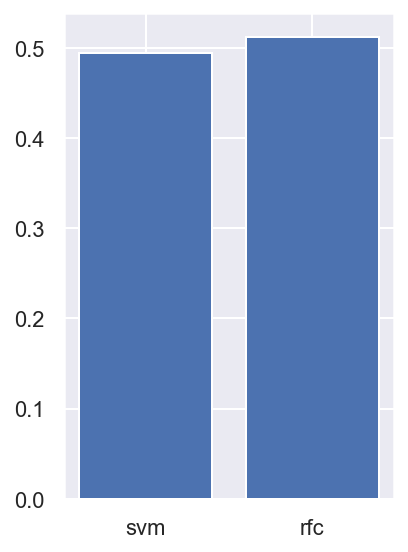

In [26]:
## Now control for shuffle labled data
data = df_z.copy()

score_svm_avg_100_s = []
score_rfc_avg_100_s = []

for j in range(100):
    milk_trials = []
    water_trials = []
    # Balance classes by their lengths
    # Rondomly pick up same amount of milk deliveries as water deliveries
    milk_trials = np.random.choice(s_lick_p1_flatten,len(s_lick_p1C_flatten))
    water_trials = s_lick_p1C_flatten

    ## Design matrix of max Ca2+ amplitude within 2 sec after the onset
    PSTH_trace = pd.DataFrame()
    for idx,time in enumerate(milk_trials):
        PSTH_trace[time]=(data[time:time+2].max().reset_index(drop=True))
    PSTH_trace = PSTH_trace.T
    PSTH_trace['Milk']=np.ones(PSTH_trace.shape[0])

    PSTH_trace_w = pd.DataFrame()
    for idx,time in enumerate(water_trials):
        PSTH_trace_w[time]=(data[time:time+2].max().reset_index(drop=True))
    PSTH_trace_w = PSTH_trace_w.T
    PSTH_trace_w['Milk']=np.zeros(PSTH_trace_w.shape[0])

    PSTH_all = pd.concat([PSTH_trace,PSTH_trace_w])
    # PSTH_all.head()
    PSTH_all_shuffle = PSTH_all.copy().reset_index(drop=True)

    ## Shuffle data labels column
    PSTH_all_shuffle['Milk'] = PSTH_all_shuffle['Milk'].sample(frac=1).reset_index(drop=True)
    
    ## Shuffle data frame (all rows), not necessary.
    PSTH_all_shuffle = PSTH_all_shuffle.sample(frac=1).reset_index(drop=True)

    ## Perform svm & rfc

    ## Set x & y
    X = PSTH_all_shuffle.iloc[:,:-1]
    y = PSTH_all_shuffle.iloc[:,-1]

    # CV
    cv = StratifiedKFold(n_splits=10)
    svc = svm.SVC(kernel='linear', probability=True)
    rfc = RandomForestClassifier()

    score_svm = []
    auc_svm = []
    score_rfc = []
    auc_rfc = []

    for i, (train, test) in enumerate(cv.split(X, y)):
        svc.fit(X.iloc[train], y.iloc[train])
        rfc.fit(X.iloc[train], y.iloc[train])

        score_svm.append(svc.score(X.iloc[test], y.iloc[test]))
        score_rfc.append(rfc.score(X.iloc[test], y.iloc[test]))
        
    score_svm_avg_100_s.append(np.mean(score_svm))
    score_rfc_avg_100_s.append(np.mean(score_rfc))    
    print('Trial:',j+1)
    print(np.mean(score_svm),np.mean(score_rfc))
plt.figure(figsize=[3,4])
plt.bar(['svm','rfc'],[np.mean(score_svm_avg_100_s),np.mean(score_rfc_avg_100_s)])
plt.tight_layout()

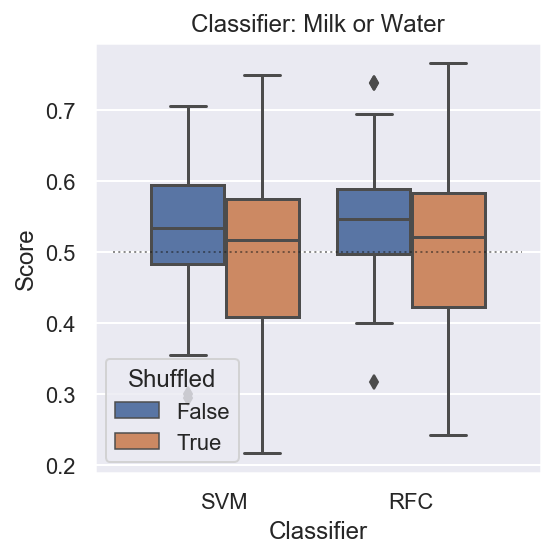

In [27]:
## Plotting setting
plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({'font.size': 8})

## More clear plot with sns
## Only with svm + rfc (combined with shuffled dat)
score = pd.DataFrame([score_svm_avg_100,score_rfc_avg_100])
score = score.T
score.columns=['SVM','RFC']
score = score.melt(var_name="Classifier")
score.columns=['Classifier','Score']
score['Shuffled'] = np.zeros(score.shape[0],dtype=bool)

score_s = pd.DataFrame([score_svm_avg_100_s,score_rfc_avg_100_s])
score_s = score_s.T
score_s.columns=['SVM','RFC']
score_s = score_s.melt(var_name="Classifier")
score_s.columns=['Classifier','Score']
score_s['Shuffled'] = np.ones(score_s.shape[0],dtype=bool)

score_all = pd.concat([score,score_s])
data = score_all
# data = score

sns.set()

from numpy import median
from scipy.stats import sem

sem_svm = sem(score_svm_avg_100)
sem_rfc = sem(score_rfc_avg_100)
error_sem = [sem_svm,sem_rfc]

std_svm = np.std(score_svm_avg_100)
std_rfc = np.std(score_rfc_avg_100)
error_std = [std_svm,std_rfc]

fig,ax = plt.subplots(figsize=[4,4])
sns.boxplot(x="Classifier", y="Score",data=data,hue='Shuffled')
plt.hlines(y=0.5,xmin=-0.6,xmax=1.6,ls=':',lw=1,label='Chance level',alpha=0.5)

plt.title('Classifier: Milk or Water')
plt.tight_layout()
plt.savefig('/Users/hunglo/Desktop/3rd_supervision/svm/svm_rfc_boxplot_'+save_file_name+'.pdf',dpi=600)
plt.show()

score_all.to_csv('/Users/hunglo/Desktop/3rd_supervision/svm/svm_rfc_score_'+save_file_name+'.csv')

In [37]:
## Load all 3 data set together

df_1 = pd.read_csv('/Users/hunglo/Desktop/3rd_supervision/svm/svm_rfc_score_BES0224200818.csv',usecols=['Score','Classifier','Shuffled'])
df_2 = pd.read_csv('/Users/hunglo/Desktop/3rd_supervision/svm/svm_rfc_score_BES0225201007.csv',usecols=['Score','Classifier','Shuffled'])
df_3 = pd.read_csv('/Users/hunglo/Desktop/3rd_supervision/svm/svm_rfc_score_BES0233200912.csv',usecols=['Score','Classifier','Shuffled'])

df_all = pd.concat([df_1,df_2,df_3]).reset_index(drop=True)
df_all

,Classifier,Score,Shuffled
0,SVM,0.666667,False
1,SVM,0.555556,False
2,SVM,0.633333,False
3,SVM,0.625000,False
4,SVM,0.700000,False
...,...,...,...
1195,RFC,0.466667,True
1196,RFC,0.475000,True
1197,RFC,0.408333,True
1198,RFC,0.566667,True


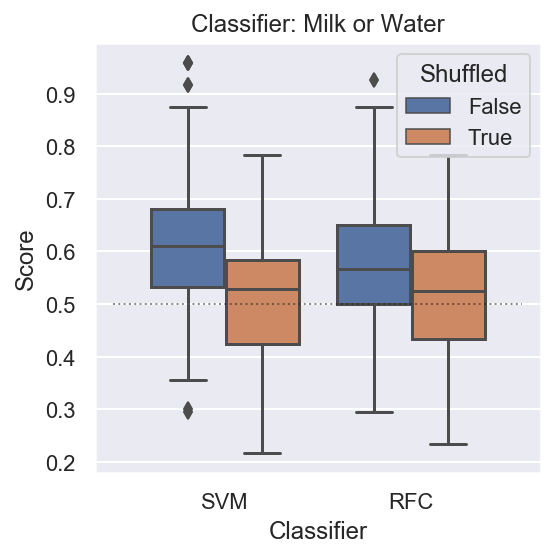

In [73]:
## Plotting setting
plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({'font.size': 8})

data = df_all

sns.set()

from numpy import median
from scipy.stats import sem

sem_svm = sem(score_svm_avg_100)
sem_rfc = sem(score_rfc_avg_100)
error_sem = [sem_svm,sem_rfc]

std_svm = np.std(score_svm_avg_100)
std_rfc = np.std(score_rfc_avg_100)
error_std = [std_svm,std_rfc]

fig,ax = plt.subplots(figsize=[4,4])
sns.boxplot(x="Classifier", y="Score",data=data,hue='Shuffled')
plt.hlines(y=0.5,xmin=-0.6,xmax=1.6,ls=':',lw=1,label='Chance level',alpha=0.5)
# plt.annotate(xy=[0.3,df_1_svm_mean],s='mouse_1',ha='center',marker='.')
# plt.plot(-0.3,df_1_svm_mean,marker='D',ls='',label='mouse_1',color='k')

plt.title('Classifier: Milk or Water')
plt.tight_layout()
plt.savefig('/Users/hunglo/Desktop/3rd_supervision/svm/svm_rfc_boxplot_all_3mice.pdf',dpi=600)
plt.show()